#**Depression Prediction**

**Data Description**

Finding if a person is depressed from their use of words on social media can definitely help in the cure!
0 stand for NO, 1 for YES

**Features Description**

Tweets

In [ ]:
pip install scikit-plot --quiet

In [ ]:
pip install tensorflow_text --quiet

In [ ]:
pip install official.nlp --quiet

In [ ]:
pip install arabert --quiet

**importing necessary packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import classification_report
import scikitplot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk. tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
# BERT imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

**Connecting to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading data**

In [ ]:
#Reading data
data = pd.read_csv("/content/drive/MyDrive/Depression Detection/AraDepSu Dataset.csv")
data.head()

,text,label
0,مش عايزه اتعلم عايزه اموت,Depression With Suicidal Ideation
1,مبحبش اقعد مع حالي كدا عشان بينتهي بيا المطاف ...,Depression With Suicidal Ideation
2,انا مش عايزة انزل الكلية ولا انزل الشارع ولا ا...,Depression With Suicidal Ideation
3,عايزه اعيش في سلام او اموت في سلام بردو اي حاجة,Depression With Suicidal Ideation
4,يارب هون هموت من الخنقه عايزه اموت,Depression With Suicidal Ideation


**pie chart of target class**

<Axes: ylabel='label'>

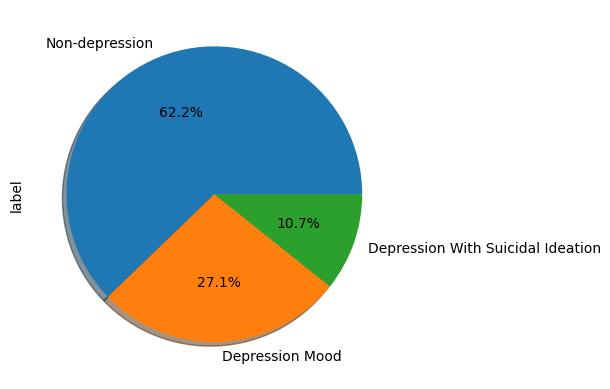

In [ ]:
data['label'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)

**Checking if data is missing**

In [ ]:
data.info()
print("------------------------")
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20214 entries, 0 to 20213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20213 non-null  object
 1   label   20213 non-null  object
dtypes: object(2)
memory usage: 316.0+ KB
------------------------


text     1
label    1
dtype: int64

In [ ]:
data= data.dropna()

In [ ]:
data= data.drop_duplicates()

In [ ]:
data['label'] = data['label'].replace('Depression With Suicidal Ideation', 'Depression Mood')

<Axes: ylabel='label'>

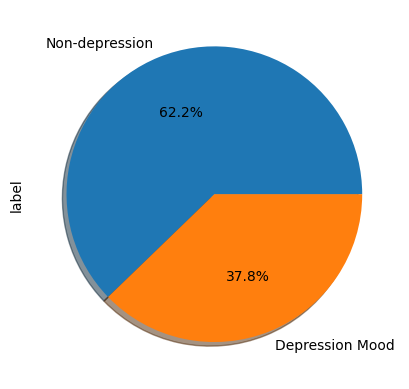

In [ ]:
data['label'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
data['label']= LabelEncoder().fit_transform(data['label'])

**Splitting tweets from Target Class**

In [ ]:
y = data.label.values
X = data.drop('label', axis=1).values

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='not minority')
X, y = undersample.fit_resample(X, y)

**Splitting data into training and testing**


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12195, 1) (12195,) (3049, 1) (3049,)


# **Model**

In [ ]:
pip install transformers --quiet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2",num_labels=1)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
# Tokenize your text
inputs = tokenizer(X_train, return_tensors="pt")
# Get the model's prediction
outputs = model (**inputs)
predictions = outputs. logits. argmax (dim=1)
print(predictions)

In [ ]:
# adapted from https://github.com/aub-mind/arabert
config = AutoConfig.from_pretrained('aubmindlab/bert-base-arabert',num_labels=2, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabert',
                                          do_lower_case=False,
                                          do_basic_tokenize=True,
                                          never_split=never_split_tokens)
model = BertForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabert', config=config)

train_dataset = SingleSentenceClassificationProcessor(mode='classification')
test_dataset = SingleSentenceClassificationProcessor(mode='classification')

train_features = train_dataset.get_features(tokenizer = tokenizer, max_length =128)
test_features = test_dataset.get_features(tokenizer = tokenizer, max_length =128)

In [ ]:
training_args = TrainingArguments("./train")
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_gpu_train_batch_size = 16
training_args.per_gpu_eval_batch_size = 16
training_args.num_train_epochs = 5

In [ ]:
# adapted from https://github.com/aub-mind/arabert

def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))

  f1_Positive = f1_score(p.label_ids,preds,pos_label=1,average='binary')
  f1_Negative = f1_score(p.label_ids,preds,pos_label=0,average='binary')
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'f1_pos': f1_Positive,
      'f1_neg': f1_Negative,
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

In [ ]:
# instantiate trainer
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = test_features,
                  compute_metrics = compute_metrics)
# start training
trainer.train()

# **AraBert Model**

In [ ]:
!git clone https://github.com/aub-mind/arabert.git

fatal: destination path 'arabert' already exists and is not an empty directory.


In [ ]:
pip install pyarabic --quiet

In [ ]:
pip install farasapy --quiet

In [ ]:
pip install transformers --quiet

In [ ]:
from arabert.preprocess import ArabertPreprocessor

model_name="bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

#X_train= arabert_prep.preprocess(X_train)
#X_test= arabert_prep.preprocess(X_test)

[2023-05-04 00:37:46,612 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

tokenized_text = tokenizer.tokenize(X_train)

input = tokenizer.convert_tokens_to_ids(tokenized_text)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://tfhub.dev/callmemehdi/AraBERT/1')
#model = hub.KerasLayer("https://tfhub.dev/callmemehdi/AraBERT/1")
#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#preprocessed_text = arabert_prep.preprocess(text_input)
outputs = model(tf.convert_to_tensor([input]))
#outputs = model(tf.convert_to_tensor([X_train]))

ValueError: ignored

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, batch_size= 164, epochs=5)

#**Model Training**

**Downloading the BERT model**

In [ ]:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# Load the AraBERT pre-processing and encoding layers
#bert_preprocess = hub. KerasLayer( "https://tfhub.dev/aubmindlab/aragpt2-base-uncased/1")
bert_encoder = hub.KerasLayer ("https://tfhub.dev/callmemehdi/AraBERT/1")

**Initializing the BERT layers**

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = arabert_prep.preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

ValueError: ignored

**Initializing the neural network layers**

In [ ]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

**Building the model**

In [ ]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

**Model Compiling**

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer='adam',
 loss='sparse_categorical_crossentropy',
 metrics=METRICS)

**Fitting the model**

In [ ]:
model.fit(X_train, y_train, batch_size= 164, epochs=1)

59/99 [================>.............] - ETA: 59:58 - loss: 0.9368 - accuracy: 0.2230  

**Evaluating model**

In [ ]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)
#yhat_test = yhat_test >= 0.5

scikitplot.metrics.plot_confusion_matrix(y_test, yhat_test, figsize=(7,7))

print(classification_report(y_test, yhat_test))